In [146]:
from paraview import simple
import numpy as np
import os
import fnmatch
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator as rgi

In [18]:
os.system('rm -f *.csv') # remove all the csv files to save memory
#time = '40000.vtk' 
patterns = ['upper_crust_t0000*[1-5][0-5]000.vtk', 'lower_crust_t00*[1-5][0-5]000.vtk'  , \
            'mantle_t00*[1-5][0-5]000.vtk']
t = []
for filename in os.listdir('.'):
    for p in patterns:        
         if fnmatch.fnmatch(filename,p):
            time = filename[-9:-4]
            t.append(time)
            reader = simple.OpenDataFile(filename)
            filename_csv = filename.replace('.vtk' , '.csv')
            name = "./" + filename_csv
            to_points = simple.CellDatatoPointData(reader) # get cell values on points
            writer = simple.CreateWriter(name, to_points)
            writer.FieldAssociation = "Points"
            writer.UpdatePipeline()

            os.system('''awk 'BEGIN { FS = "," }/[0-9]$/{print $22, $23, $24, $25}' ''' \
            + filename_csv + ''' >> diff_stress''' + time + '''.csv''') # get diff stress and points


10000


In [168]:
t = list(set(t))
for j in range(len(t)):
    file_ds = 'diff_stress' + t[j] + '.csv'
    dat = np.loadtxt(file_ds)

    dat_sort = np.ones((7168, 4))
    dat_shap = np.reshape(dat, (3, 7168, 4 )) # get values for all points 
    dat_sort[:,1: 4] = dat_shap[0, :, 1:4] # get points
    dat_sort[:,0] = np.sum( dat_shap[:, :, 0], axis=0) # get values accurately
    dat_sort[dat_sort[:,3] == -20000 ,0] = (dat_sort[dat_sort[:,3] == -20000, 0])/2.
    dat_sort[dat_sort[:,3] == -40000 ,0] = (dat_sort[dat_sort[:,3] == -40000, 0])/2.

    x = np.unique(dat_sort[:,1])
    y = np.unique(dat_sort[:,2])
    z = np.unique(dat_sort[:,3]) # get query points along which we want interpolation
    
    ind = np.lexsort((dat_sort[:,2], dat_sort[:,3])) # arrange data for meshgrid
    data_yz = dat_sort[ind, :] # sort the data to make meshgrid

    for i in range(16*28): # sort the x values
        index = np.argsort(data_yz[0 + 16*i : 16 + 16*i, 1]) + 16*i
        data_yz[0 + 16*i : 16 + 16*i, 0:2] = data_yz[index, 0:2]
        
    diff_stress = np.reshape(data_yz[:,0], (28, 16, 16))
    
    figure,  (ax1, ax2) = plt.subplots(1, 2,  figsize=(12, 10))   
    figure.suptitle("Time = %s years" %(t[j]) , fontsize=20, y=0.78)

    CB = ax1.imshow(diff_stress[25,4:12,4:12], cmap='plasma',  vmin=-2.4e8, vmax=-0.1e8)
    figure.subplots_adjust(right=0.8)
    cbar_ax = figure.add_axes([ 0.15, 0.25, 0.6, 0.03])
    #cbar_ax.set_aspect(2)
    figure.colorbar(CB, cax=cbar_ax, orientation='horizontal', label='Differential Stress in Pa')    
    
    diff_stress = np.flip(diff_stress, 0)
    
    CB2 = ax2.imshow(diff_stress[:,8,4:12], cmap='plasma')
    # Turn off tick labels
    ax1.set_yticklabels([])
    ax1.set_xticklabels([])
    # Turn off tick labels
    ax2.set_yticklabels([])
    ax2.set_xticklabels([])
    
    ax1.set_title('Depth section at 4 km', fontsize=18 )
    ax1.set_xlabel('Along X direction', fontsize=16)
    ax1.set_ylabel('Along Y direction ', fontsize=16)
    ax2.set_title('Crossection at y=7000 km', fontsize=18 )
    ax2.set_aspect(0.2)
    ax2.set_xlabel('Along X direction', fontsize=16)
    ax2.set_ylabel('Along Z direction ', fontsize=16)
#     cbar = figure.colorbar(CB, orientation='horizontal')
#     plt.colorbar(CB)
    plt.savefig('figure2_%s.png' %(t[j]), bbox_inches='tight', pad_inches=0, dpi=400)
#    plt.show()

/home/sushi/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [44]:
t= list(set(t))
print(t)

['40000', '50000', '14000', '12000', '34000', '30000', '10000', '22000', '44000', '32000', '42000', '20000', '24000']


In [23]:
# xp = 888000 ; yp = 777000
# #---------------------------------------------------------------
# query = np.column_stack((z, yp*np.ones(len(z)), xp*np.ones(len(z))))

ind = np.lexsort((dat_sort[:,2], dat_sort[:,3])) # arrange data for meshgrid
data_yz = dat_sort[ind, :] # sort the data to make meshgrid

for i in range(16*28): # sort the x values
  index = np.argsort(data_yz[0 + x*i : x + x*i, 1]) + x*i
  data_yz[0 + x*i : x + x*i, 0:2] = data_yz[index, 0:2]

diff_stress = np.reshape(data_yz[:,0], (z, y, x))
np.savetxt('data.txt', data_yz)

# fn = rgi((np.sort(z) , np.sort(y) , np.sort(x)), diff_stress)
# plot_over_line = (fn(query))

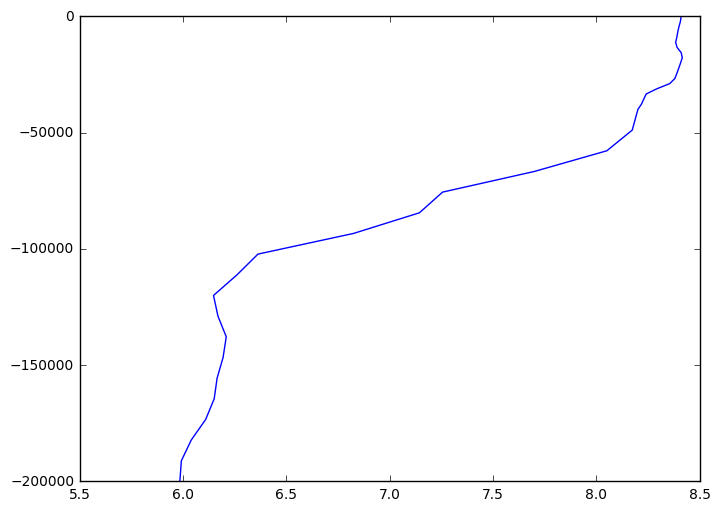

In [34]:
plt.figure(figsize=(8,6))
plt.plot(np.log10(np.abs(plot_over_line)), np.sort(z))
plt.show()
plt.savefig('plot_depth.png', bbox_inches='tight', pad_inches=0, dpi=400)

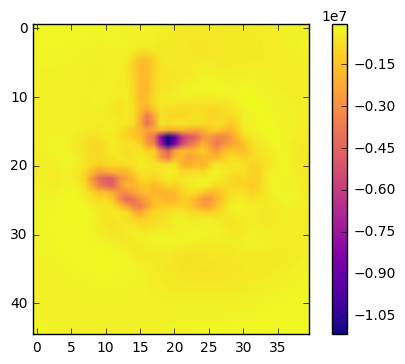

In [25]:
CB = plt.imshow(diff_stress[0,15:60,20:60], cmap='plasma')
plt.colorbar(CB)
plt.show()